# Atmospheric Effects on DORIS

## Objectives
* Overview of (DORIS) signal delay during its transition through the atmosphere
* Modeling of tropospheric refraction, and
* Using VMF3 to model/mitigate tropospheric delay

## Troposphere

In [4]:
# Section 1 - Imports

import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join

from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

# Section 1.2 – Define File Paths
data_path = "../../data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")

# Section 1.3 - Load Sp3 + Initialize Interpolator 
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
sp3_id = list(intrp._interpolators.keys())[0]

# Section 1.4 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
rnx = DorisRinex(drinex)

# Section 1.5 - Choose a station and get coordinates (DIOB DORIS beacon)
site_name = 'DIOB'
diob_crd = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True)[site_name]
rsta = np.array([diob_crd['X'], diob_crd['Y'], diob_crd['Z']])
lat, lon, hgt = transformations.car2ell(*rsta)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

The total delay time which radio waves experience when traveling through the neutral atmosphere depending on the observation elevation angle ($e$) is commonly modeled with the parametrization:
$$
\Delta L(\varepsilon ) = \Delta L_\mathrm{h}^\mathrm{z} \cdot \hbox {mf}_\mathrm{h}(\varepsilon ) + \Delta L_\mathrm{w}^\mathrm{z} \cdot \hbox {mf}_\mathrm{w}(\varepsilon )
$$

where:
- $\Delta L(\varepsilon )$ total delay in [m],
- $\Delta L_\mathrm{h}^\mathrm{z}$ zenith path delay due to the hydrostatic part of neutral atmosphere,
- ${mf}_\mathrm{h}(\varepsilon )$ mapping function for the hydrostatic component,
- $\Delta L_\mathrm{w}^\mathrm{z}$ zenith path delay due to the wet part of neutral atmosphere, and
- ${mf}_\mathrm{w}(\varepsilon )$ mapping function for the wet component

Evidently, delay modeling is split into a hydrostatic (dry) part, which is mainly caused by the dry gases in the atmosphere, and a wet part which arises from water vapor and water particles in the atmosphere, each represented through a multiplication of the respective delay in zenith direction with a mapping function . The zenith hydrostatic delay can be determined with very high precision through pressure measurements at the site, as the weight of all air layers adds up to the surface pressure (Landskron & Böhm (2018)).

### Hydrostatic Part

The most widely used formula to compute $\Delta L_\mathrm{h}^\mathrm{z}$ is due to Saastamoinen (1972) as revised by Davis et al. (1985), and reads:
$$
\Delta L_\mathrm{h}^\mathrm{z} = \frac{0.0022768 \cdot p}{1-0.00266 \cdot \cos (2\varphi )-0.28 \cdot 10^{-6} \cdot h_\mathrm{ell}}
$$
with $p$ being the pressure value (at the site) and and $\varphi$, $h_\mathrm{ell}$ the geographic latitude and ellipsoidal height of the station, respectively. We could use the DORIS-derived pressure values (from the RINEX files) to compute $\Delta L_\mathrm{h}^\mathrm{z}$:

In [5]:
# precompute the denominator
denom = 1. - 266e-5 * np.cos(2. * lat) - .28e-6 * hgt
def dlzh(pressure): return 22768e-7 * pressure

# lets store results to plot them later on
ts = []; dL = []; pr = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # get pressure value 
            pressure = data['P']['value']

            # compute delay
            delay = dlzh(pressure)
            
            ts.append(tai)
            dL.append(delay)
            pr.append(pressure)

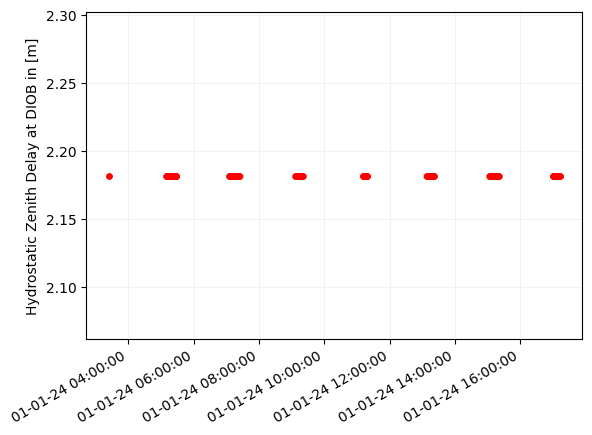

In [6]:
# Plot results w.r.t time ...
plt.scatter([at2pt(ti) for ti in ts], dL, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Hydrostatic Zenith Delay at {site_name} in [m]")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

Measured pressure values remain constant (in this case 958.400 $mbar$) which forces the $\Delta L_\mathrm{h}^\mathrm{z}$ to hold a constant value trhoughout the time interval.

There are more precise ways to get $\Delta L_\mathrm{h}^\mathrm{z}$; here, we will be using the Site-wise VMF3 products, from the VMF [Data Server](https://vmf.geo.tuwien.ac.at/) (re3data.org: VMF Data Server; editing status 2020-12-14; re3data.org - Registry of Research Data Repositories. http://doi.org/10.17616/R3RD2H). Products include site-specific information, including both pressure and pre-computed $\Delta L_\mathrm{h}^\mathrm{z}$ for all active DORIS sites. We can extract the $\Delta L_\mathrm{h}^\mathrm{z}$ values from such data files, and compare to computed values using the DORIS RINEX pressure records.

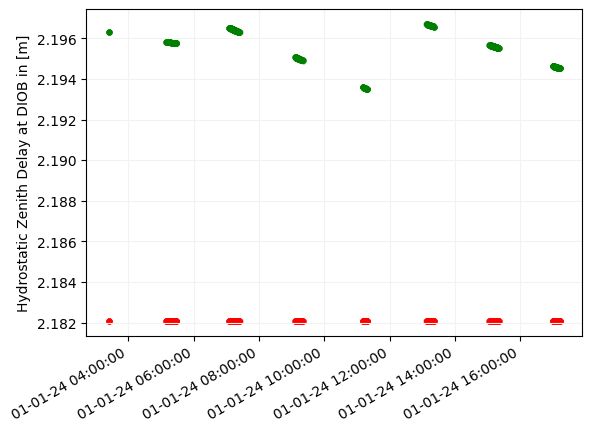

In [7]:
# VMF3 site-specific data for 2024
vmf3_data = join(data_path, "y2024.vmf3_d")
# Initialize VMF3 from (DORIS) site data
vmf = SiteVmf3(vmf3_data, site_name)
# Request VMF3 for each epoch in the ts array
vmf3_dL = [ vmf.tropo_dealy_info(site_name, lat, lon, np.pi/4., t) for t in [at2pt(ti) for ti in ts] ]
# Plot
plt.scatter([at2pt(ti) for ti in ts], dL, alpha=0.5, s=12, c='red')
plt.scatter([at2pt(ti) for ti in ts], [d["zhd"] for d in vmf3_dL], alpha=0.5, s=12, c='green')
plt.grid(color='0.95')
plt.ylabel(f"Hydrostatic Zenith Delay at {site_name} in [m]")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

### Wet Part

Deriving the zenith wet delay $\Delta L_\mathrm{w}^\mathrm{z}$, is far more difficult because surface measurements alone are not sufficient for this. Common practice in space geodesy is to estimate this parameter in the analysis on the basis of a sufficient overdetermination of observations (Landskron & Böhm (2018)). Approximate values for $\Delta L_\mathrm{w}^\mathrm{z}$ can be computed by various formulae (e.g. Askne and Nordius (1987)), or extraced from product files. In this case, we we will be using the Site-wise VMF3 products, from the VMF [Data Server](https://vmf.geo.tuwien.ac.at/) to get zenith wet delay values for a site of interest. All the information we want is already extraced above and stored in the `vmf3_dL` struct:

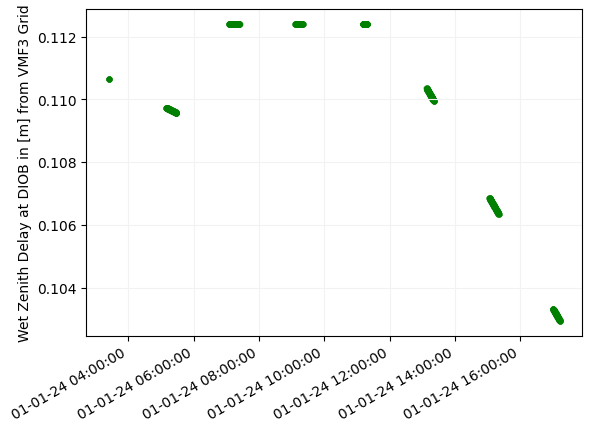

In [8]:
plt.scatter([at2pt(ti) for ti in ts], [d["zwd"] for d in vmf3_dL], alpha=0.5, s=12, c='green')
plt.grid(color='0.95')
plt.ylabel(f"Wet Zenith Delay at {site_name} in [m] from VMF3 Grid")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

### Mapping Functions

Mapping functions (for the hydrostatic and wet compinent), map the zenith delay values to given elevations. Most "modern" mapping functions, have the general form:

$$
\hbox {mf}(\varepsilon ) = \frac{1+\frac{a}{1+\frac{b}{1+c}}}{\sin (\varepsilon )+\frac{a}{\sin (\varepsilon )+\frac{b}{\sin (\varepsilon )+c}}}
$$

We can use the VMF3 model to map $\Delta L_\mathrm{h}^\mathrm{z}$ and $\Delta L_\mathrm{w}^\mathrm{z}$ values to total zenith dealy at the elevation angle of each observation:

In [9]:
# lets store results to plot them later on
ts = []; dL = []; elvs = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # satellite position
            satx, saty, satz, _ = intrp.sat_at(sp3_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute range, azimouth and elevation between site and satellite
            r, az, el = transformations.azele(rsat, rsta)

            # compute tropospheric delay at elevation
            delay = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
            
            ts.append(tai)
            dL.append(delay)
            elvs.append(np.degrees(el))

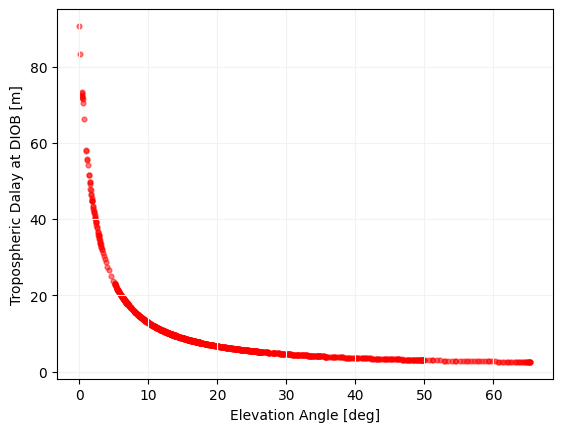

In [10]:
# Plot tropospheric delay Vs Elevation
plt.scatter(elvs, dL, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Tropospheric Dalay at {site_name} [m]")
plt.xlabel(f"Elevation Angle [deg]")
plt.show()

## Tropospheric Bias in Doppler Observations

When forming Doppler observations, we actually take the differrence between two consecutive carrier phase observations, i.e. 
$$
\frac{\Delta \phi}{\Delta t} \lambda = \frac{\phi (t_2) - \phi (t_1)}{\Delta t} \cdot \frac{c}{f} \approx \frac{\rho (t_2) - \rho (t_1)}{\Delta t} \approx \dot{\rho} 
$$ in units of $m/sec$ where:

- $\phi (t_i)$ is the carrier wave phase observation at instant $t_i$,
- $\Delta t$ time interval, in seconds, between $t_2$ and $t_1$,
- $c$ speed of light,
- $f$ (nominal) frequency, and
- $\rho _{t_i}$ range (satellite-beacon distance) at $t_i$

and
$$
\frac{c}{f} \phi (t_i) \approx \rho (t_i) + \delta T - \delta I + N + \dots
$$

Each carrier-phase observation $\phi (t_i)$ is affected by tropospheric delay $\delta T(t_i)$, hence to mitigate tropospheric dealy from the Doppler observation equation we have to compute
$$
\delta T = \frac{\delta T(t_2, el(t_2)) - \delta T(t_1, el(t_1))}{\Delta t}
$$

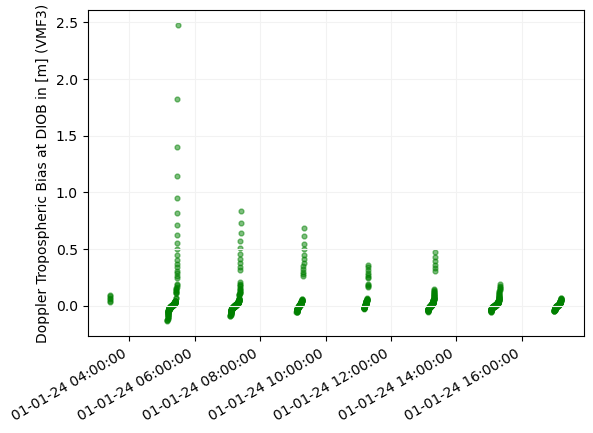

In [12]:
# lets store results to plot them later on
ts = []; dL = []; elvs = [];

# last data
last_tai = None
last_dti = None
last_ele = None

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # satellite position
            satx, saty, satz, _ = intrp.sat_at(sp3_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute range, azimouth and elevation between site and satellite
            r, az, el = transformations.azele(rsat, rsta)

            # compute tropospheric delay at elevation
            dti = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))

            # compute difference to previous obs, if any
            if last_tai is not None and (tai - last_tai).total_seconds() <= 10.:
                dt = float((tai - last_tai).total_seconds())
                ts.append(tai)
                dL.append( (dti-last_dti)/dt )
                elvs.append( np.degrees(el)+(np.degrees(el)-np.degrees(last_ele))/2. )

            # assign values for next computation
            last_tai = tai
            last_dti = dti
            last_ele = el

# Plot results
plt.scatter([at2pt(ti) for ti in ts], dL, alpha=0.5, s=12, c='green')
plt.grid(color='0.95')
plt.ylabel(f"Doppler Tropospheric Bias at {site_name} in [m] (VMF3)")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

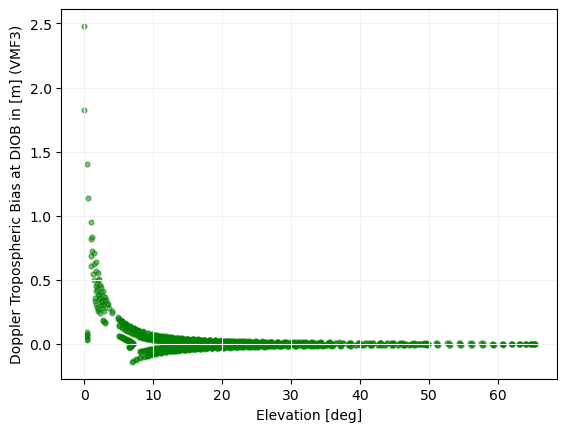

In [13]:
# Plot results
plt.scatter(elvs, dL, alpha=0.5, s=12, c='green')
plt.grid(color='0.95')
plt.ylabel(f"Doppler Tropospheric Bias at {site_name} in [m] (VMF3)")
plt.xlabel(f"Elevation [deg]")
ax = plt.gca()
plt.show()